In [ ]:
# Part 1 - Dataset Preprocessing

# Part 1: Dataset Preprocessing



## Part1.1

In [1]:

import json, os, getpass, pathlib, sys

KAGGLE_JSON = "/root/.kaggle/kaggle.json"
pathlib.Path("/root/.kaggle").mkdir(parents=True, exist_ok=True)
if not os.path.exists(KAGGLE_JSON):
    kaggle_token = getpass.getpass("kaggle json : ")
    with open(KAGGLE_JSON, "w") as f:
        f.write(kaggle_token.strip())
    os.chmod(KAGGLE_JSON, 0o600)

!pip -q install kaggle pandas numpy pyarrow python-dateutil matplotlib seaborn


kaggle json : ··········


In [5]:
import os, zipfile, glob
BASE = "/content/one_million_news"
os.makedirs(BASE, exist_ok=True)

# Correct slug: pooyagh/one-million-news
!kaggle datasets download -d pooyagh/one-million-news -p {BASE} -q

for z in glob.glob(f"{BASE}/*.zip"):
    with zipfile.ZipFile(z, "r") as zf:
        zf.extractall(BASE)

print("Files under", BASE)
!ls -lah {BASE} | sed -n '1,120p'


Dataset URL: https://www.kaggle.com/datasets/pooyagh/one-million-news
License(s): MIT
Files under /content/one_million_news
total 2.0G
drwxr-xr-x 2 root root 4.0K Nov  8 08:24 .
drwxr-xr-x 1 root root 4.0K Nov  8 08:24 ..
-rw-r--r-- 1 root root 1.2G Nov  8 08:24 articles_mapped.h5
-rw-r--r-- 1 root root 804M Sep 16 19:23 one-million-news.zip


In [7]:
from pathlib import Path
import os, json, textwrap, pandas as pd, numpy as np

BASE = Path("/content/one_million_news")
H5   = BASE / "articles_mapped.h5"
KEY  = "data"
RANDOM_STATE = 42

OUT_P1 = Path("/content/ir_outputs/part1"); OUT_P1.mkdir(parents=True, exist_ok=True)
OUT_P2 = Path("/content/ir_outputs/part2"); OUT_P2.mkdir(parents=True, exist_ok=True)

def write_report(path: Path, text: str):
    path.write_text(text.strip() + "\n", encoding="utf-8")
    print("Wrote report →", path)


In [8]:

import os, zipfile, glob

#!kaggle datasets download -d pooyagh/one-million-news -p {BASE} -q

for z in glob.glob(f"{BASE}/*.zip"):
    with zipfile.ZipFile(z, "r") as zf:
        zf.extractall(BASE)

print("Files under", BASE)
!ls -lah {BASE} | sed -n '1,120p'

Files under /content/one_million_news
total 2.0G
drwxr-xr-x 2 root root 4.0K Nov  8 08:24 .
drwxr-xr-x 1 root root 4.0K Nov  8 08:24 ..
-rw-r--r-- 1 root root 1.2G Nov  8 08:25 articles_mapped.h5
-rw-r--r-- 1 root root 804M Sep 16 19:23 one-million-news.zip


In [9]:
# Load only needed columns (saves RAM)

df = pd.read_hdf(H5, key=KEY)

# Derive year
df["pub_date"] = pd.to_datetime(df["pub_date"], errors="coerce", utc=True)
df["year"] = df["pub_date"].dt.year.astype("Int64")

# Reports
total_docs = len(df)
cat_counts = (df["mapped_section"].astype("string").str.strip()
              .replace({"": pd.NA}).dropna()
              .value_counts().rename_axis("category")
              .reset_index(name="count"))
year_counts = (df.dropna(subset=["year"])
               .groupby("year").size()
               .reset_index(name="count").sort_values("year"))

# Save tables
cat_counts_csv  = OUT_P1 / "category_counts.csv"
year_counts_csv = OUT_P1 / "year_counts.csv"
cat_counts.to_csv(cat_counts_csv, index=False)
year_counts.to_csv(year_counts_csv, index=False)

# TXT report
rep = f"""
Part 1.1 — Load & Overview
===========================
Source HDF5 : {H5}
Key         : {KEY}

Total number of documents: {total_docs:,}

Category counts CSV : {cat_counts_csv}
Year counts CSV     : {year_counts_csv}

(categories):
{cat_counts.to_string(index=False)}

(years):
{year_counts.to_string(index=False)}
"""
write_report(OUT_P1 / "part1.1_report.txt", rep)


Wrote report → /content/ir_outputs/part1/part1.1_report.txt


In [10]:
df.columns

Index(['web_url', 'pub_date', 'text', 'section_name', 'mapped_section',
       'year'],
      dtype='object')

## Part 1.2:


In [11]:


df_valid = df.dropna(subset=["year", "mapped_section"]).copy()
df_valid["mapped_section"] = df_valid["mapped_section"].astype("string").str.strip()

sampled = (
    df_valid
    .groupby(["year", "mapped_section"], group_keys=False, sort=False)
    .apply(lambda x: x.sample(frac=0.10, random_state=RANDOM_STATE))
    .reset_index(drop=True)
)

# Pivot tables
pivot_counts = sampled.pivot_table(index="year", columns="mapped_section", values="text",
                                   aggfunc="count", fill_value=0)
orig_counts = df_valid.pivot_table(index="year", columns="mapped_section", values="text",
                                   aggfunc="count", fill_value=0).reindex_like(pivot_counts).fillna(0)
percentages = (pivot_counts / orig_counts.replace(0, np.nan) * 100).round(1)
percentages = percentages.replace([np.inf, -np.inf], np.nan).fillna(0)

# Totals (add AFTER percentage to avoid inf)
pivot_counts["Total"] = pivot_counts.sum(axis=1)
percentages["Total"]  = (pivot_counts["Total"] / orig_counts.sum(axis=1).replace(0, np.nan) * 100).round(1).fillna(0)
pivot_counts.loc["Total"] = pivot_counts.sum(axis=0)
percentages.loc["Total"]  = percentages.drop(columns=["Total"]).mean(axis=0).round(1)

# Save artifacts
sampled_csv        = OUT_P1 / "articles_mapped_small.csv"
pivot_counts_csv   = OUT_P1 / "sample_counts_table.csv"
percentages_csv    = OUT_P1 / "sample_percentages_table.csv"
sampled.to_csv(sampled_csv, index=False)
pivot_counts.to_csv(pivot_counts_csv)
percentages.to_csv(percentages_csv)

rep = f"""
Part 1.2 — 10% Stratified Sampling
==================================
Sampling: 10% per (year × mapped_section), random_state={RANDOM_STATE}

Original (valid) docs: {len(df_valid):,}
Sampled  (10%) docs  : {len(sampled):,}

Saved:
- Sampled dataset            : {sampled_csv}
- Counts (year×category)     : {pivot_counts_csv}
- Percentages (year×category): {percentages_csv}

Sanity (should be ~10% per cell):
Sample percentages (head):
{percentages.head(8).to_string()}
"""
write_report(OUT_P1 / "part1.2_report.txt", rep)


/tmp/ipython-input-2151344920.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.10, random_state=RANDOM_STATE))


Wrote report → /content/ir_outputs/part1/part1.2_report.txt


## Part 1.3:

In [12]:
# Reset just those two options
pd.reset_option('display.max_colwidth')
pd.reset_option('display.width')

In [13]:
# Config
LOWERCASE = True
NORMALIZE_WHITESPACE = True
REPLACE_DIGITS = True
REMOVE_PUNCT = True
REMOVE_STOPWORDS = False  # keep for embeddings

import re
_re_multi_ws = re.compile(r"\s+")
_re_digits   = re.compile(r"\d+")
_re_punct    = re.compile(r"[^\w\s]")
TOKEN_PATTERN = re.compile(r"[A-Za-z]+|<NUM>")

def preprocess_text(s: str) -> str:
    if not isinstance(s, str) or not s.strip(): return ""
    if LOWERCASE:        s = s.lower()
    if REPLACE_DIGITS:   s = _re_digits.sub("<NUM>", s)
    if REMOVE_PUNCT:
        s = s.replace("<NUM>", " __NUM__ ")
        s = _re_punct.sub(" ", s)
        s = s.replace("__NUM__", "<NUM>")
    tokens = TOKEN_PATTERN.findall(s)
    out = " ".join(tokens)
    if NORMALIZE_WHITESPACE:
        out = _re_multi_ws.sub(" ", out).strip()
    return out

sampled = sampled.copy()
sampled["text_clean"] = sampled["text"].astype(str).apply(preprocess_text)

# Save
preproc_csv = OUT_P1 / "articles_mapped_small_preprocessed.csv"
sampled.to_csv(preproc_csv, index=False)

# examples
examples = sampled.sample(min(5, len(sampled)), random_state=42)[["section_name", "mapped_section","year","text","text_clean"]]

rep = f"""
Part 1.3 — Preprocessing
========================
Pipeline:
- lowercasing={LOWERCASE}
- whitespace normalization={NORMALIZE_WHITESPACE}
- punctuation removal={REMOVE_PUNCT}
- digit handling -> <NUM>={REPLACE_DIGITS}
- tokenizer: regex (A–Z words + <NUM>)
- stopwords removed? {REMOVE_STOPWORDS} (kept to preserve context for embeddings)

Saved preprocessed sample:
{preproc_csv}

Examples (5 rows):
{examples.to_string(index=False)}
"""
write_report(OUT_P1 / "part1.3_report.txt", rep)


Wrote report → /content/ir_outputs/part1/part1.3_report.txt


## Part 1.4:

In [14]:
# Ensure year ok and text_clean exists
dfp = sampled.dropna(subset=["year"]).copy()
dfp["year"] = dfp["year"].astype(int)
if "text_clean" not in dfp.columns:
    dfp["text_clean"] = dfp["text"].astype(str).apply(preprocess_text)

dec1 = dfp[(dfp["year"] >= 2005) & (dfp["year"] < 2015)].copy()
dec2 = dfp[(dfp["year"] >= 2015) & (dfp["year"] <= 2025)].copy()

# Save CSVs
dec1_csv = OUT_P1 / "articles_mapped_preprocessed_decade1.csv"
dec2_csv = OUT_P1 / "articles_mapped_preprocessed_decade2.csv"
dec1.to_csv(dec1_csv, index=False)
dec2.to_csv(dec2_csv, index=False)

# Save corpora
dec1_txt = OUT_P1 / "corpus_decade1.txt"
dec2_txt = OUT_P1 / "corpus_decade2.txt"
dec1["text_clean"].to_csv(dec1_txt, index=False, header=False)
dec2["text_clean"].to_csv(dec2_txt, index=False, header=False)

# Category distributions
dec1_cat = (dec1["mapped_section"].astype(str).str.strip().value_counts()
            .rename_axis("category").reset_index(name="count"))
dec2_cat = (dec2["mapped_section"].astype(str).str.strip().value_counts()
            .rename_axis("category").reset_index(name="count"))
dec1_cat_csv = OUT_P1 / "decade1_category_distribution.csv"
dec2_cat_csv = OUT_P1 / "decade2_category_distribution.csv"
dec1_cat.to_csv(dec1_cat_csv, index=False)
dec2_cat.to_csv(dec2_cat_csv, index=False)

rep = f"""
Part 1.4 — Decade Splits & Corpora
==================================
Decade 1: 2005–2014 → rows: {len(dec1):,}
Decade 2: 2015–2025 → rows: {len(dec2):,}

Saved:
- Decade 1 CSV : {dec1_csv}
- Decade 2 CSV : {dec2_csv}
- corpus_decade1.txt : {dec1_txt}
- corpus_decade2.txt : {dec2_txt}
- Decade 1 category distribution: {dec1_cat_csv}
- Decade 2 category distribution: {dec2_cat_csv}

Head (Decade 1 cats):
{dec1_cat.head(10).to_string(index=False)}

Head (Decade 2 cats):
{dec2_cat.head(10).to_string(index=False)}
"""
write_report(OUT_P1 / "part1.4_report.txt", rep)


Wrote report → /content/ir_outputs/part1/part1.4_report.txt


In [15]:
print(dec1.shape)
print(dec2.shape)

(59568, 7)
(41133, 7)


## Part 5:

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

GENERIC_TERMS = {
    "a","an","and","are","as","at","be","been","being","but","by","for","from","had","has","have",
    "he","her","hers","him","his","i","if","in","into","is","it","its","me","my","of","on","or",
    "our","ours","she","so","that","the","their","them","they","this","those","to","was","we",
    "were","what","when","where","which","who","will","with","would","you","your",
    "news","new","today","yesterday","day","week","month","year","time","story","report","update",
    "article","said","says","according","more","latest","one","two","three","first","last","next",
    "international","national","local","global","world","country","city","state","region",
    "official","minister","government","president","leader","organization","agency",
    "company","market","business","economy","economic","financial",
    "technology","tech","innovation","industry","service","services","firm",
    "team","match","game","season","player","coach","league","score","win","lose","victory",
    "science","scientific","research","study","project","education","student","school",
    "university","college","teacher","health","medical","hospital","doctor","patient","disease",
    "treatment","culture","life","lifestyle","art","arts","fashion","style","music","film","movie",
    "food","travel","tourism","politics","political","election","vote","party","policy",
    "parliament","law","lawmakers","prime","campaign","around","about","across","after","before",
    "during","between","within","without","through","throughout","while","such","every","each",
    "<num>","num","http","https","www","com"
}
GENERIC_TERMS = {w.lower() for w in GENERIC_TERMS}

def top_term_per_category(df_decade, min_df=5, max_df=0.85):
    vec = TfidfVectorizer(lowercase=False, token_pattern=r"(?u)\b\w\w+\b",
                          min_df=min_df, max_df=max_df, sublinear_tf=True, ngram_range=(1,1))
    X = vec.fit_transform(df_decade["text_clean"])
    vocab = np.array(vec.get_feature_names_out())
    vocab_lower = np.char.lower(vocab.astype(str))
    generic_mask = np.isin(vocab_lower, list(GENERIC_TERMS))

    cats = df_decade["mapped_section"].astype(str).str.strip().values
    categories = pd.Index(sorted(pd.unique(cats)))
    rows = []
    for cat in categories:
        idx = np.where(cats == cat)[0]
        if len(idx) == 0: continue
        mean_tfidf = np.asarray(X[idx].mean(axis=0)).ravel()
        mask_valid = (~generic_mask) & (mean_tfidf > 0)
        if not np.any(mask_valid):
            rep = vocab[int(mean_tfidf.argmax())]
        else:
            rep = vocab[int(np.argmax(mean_tfidf * mask_valid))]
        rows.append({"category": cat, "representative_word": rep, "docs_in_cat": len(idx)})
    return pd.DataFrame(rows).sort_values("category").reset_index(drop=True)

d1_words = top_term_per_category(dec1)
d2_words = top_term_per_category(dec2)

w1 = OUT_P1 / "words_decade1.txt"
w2 = OUT_P1 / "words_decade2.txt"
d1_words.to_csv(w1, sep="\t", index=False, header=False, columns=["category","representative_word"])
d2_words.to_csv(w2, sep="\t", index=False, header=False, columns=["category","representative_word"])

rep = f"""
Part 1.5 — Representative Words
================================
Method: Per-decade TF-IDF; per-category mean TF-IDF; pick top non-generic unigram.

Saved:
- Decade 1 word list : {w1}
- Decade 2 word list : {w2}

Head (Decade 1):
{d1_words.head(10).to_string(index=False)}

Head (Decade 2):
{d2_words.head(10).to_string(index=False)}
"""
write_report(OUT_P1 / "part1.5_report.txt", rep)


Wrote report → /content/ir_outputs/part1/part1.5_report.txt


## Part 1.6:

In [45]:
# Download
!pip -q install kaggle
import glob, zipfile, os
NF_SLUG = "manupande21111997/nfcorpus-train-all-rel-and-irrel-docs"
BASE_NF = Path("/content/nfcorpus"); BASE_NF.mkdir(exist_ok=True, parents=True)
!kaggle datasets download -d {NF_SLUG} -p {BASE_NF} -q
for z in glob.glob(f"{BASE_NF}/*.zip"):
    with zipfile.ZipFile(z, "r") as zf:
        zf.extractall(BASE_NF)

# Load largest CSV/TSV
files = sorted(glob.glob(str(BASE_NF / "**/*"), recursive=True))
cands = [f for f in files if f.endswith((".csv",".tsv"))]
nf_path = max(cands, key=os.path.getsize)
sep = "\t" if nf_path.endswith(".tsv") else ","
nf = pd.read_csv(nf_path, sep=sep, on_bad_lines="skip")

# Preprocess text columns (reuse same function)
text_cols = ['query', 'doc']
for c in text_cols:
    nf[f"{c}_clean"] = nf[c].astype(str).apply(preprocess_text)

# Map labels → relevance_binary
rel_col = "relevance"
if rel_col not in nf.columns:
    alt = [c for c in nf.columns if "rel" in c.lower() or "label" in c.lower()]
    assert alt, "No relevance column found."
    nf = nf.rename(columns={alt[0]: rel_col})
nf["relevance_binary"] = nf[rel_col].apply(lambda x: 1 if x in [1,2,3] else 0)


qcol = 'query_id'

# Per-query stats
rel_stats = (nf.groupby(qcol)["relevance_binary"]
             .agg(["sum","count"]).rename(columns={"sum":"relevant_docs","count":"total_docs"}))
rel_stats["rel_ratio"] = rel_stats["relevant_docs"] / rel_stats["total_docs"]

avg_rel   = rel_stats["relevant_docs"].mean()
med_rel   = rel_stats["relevant_docs"].median()
pct_zero  = (rel_stats["relevant_docs"] == 0).mean() * 100

# Save preprocessed NFCorpus
nf_out = OUT_P1 / "nfcorpus_preprocessed.csv"
nf.to_csv(nf_out, index=False)

rep = f"""
Part 1.6 — NFCorpus Preprocessing
=================================
Dataset           : {nf_path}
Detected text cols: {text_cols}
Query column      : {qcol}
Label column      : {rel_col}

Relevance mapping: 1–3 ⇒ 1 (relevant), 0/others ⇒ 0

Saved preprocessed NFCorpus: {nf_out}

Per-query statistics:
- Average # relevant docs : {avg_rel:.2f}
- Median  # relevant docs : {med_rel:.2f}
- % queries with 0 relevant: {pct_zero:.2f}%

Head of per-query table:
{rel_stats.head(10).to_string()}
"""
write_report(OUT_P1 / "part1.6_report.txt", rep)


Dataset URL: https://www.kaggle.com/datasets/manupande21111997/nfcorpus-train-all-rel-and-irrel-docs
License(s): unknown
Wrote report → /content/ir_outputs/part1/part1.6_report.txt


In [46]:
len(nf)
nf.head()

,query_id,doc_id,query,doc,relevance,query_clean,doc_clean,relevance_binary
0,PLAIN-3,MED-2436,breast cancer cells feed on cholesterol one in...,content low density lipoprotein receptors brea...,3,breast cancer cells feed on cholesterol one in...,content low density lipoprotein receptors brea...,1
1,PLAIN-3,MED-2437,breast cancer cells feed on cholesterol one in...,diet breast cancer understanding risks benefit...,3,breast cancer cells feed on cholesterol one in...,diet breast cancer understanding risks benefit...,1
2,PLAIN-3,MED-2438,breast cancer cells feed on cholesterol one in...,association dietary lignans phytoestrogen-rich...,3,breast cancer cells feed on cholesterol one in...,association dietary lignans phytoestrogen rich...,1
3,PLAIN-3,MED-2439,breast cancer cells feed on cholesterol one in...,plant sterols anticancer nutrients evidence ro...,3,breast cancer cells feed on cholesterol one in...,plant sterols anticancer nutrients evidence ro...,1
4,PLAIN-3,MED-2440,breast cancer cells feed on cholesterol one in...,total cholesterol cancer risk large prospectiv...,3,breast cancer cells feed on cholesterol one in...,total cholesterol cancer risk large prospectiv...,1


# Part 2: Word Embedding

## Part 2.1:

In [18]:
!pip -q install -U "gensim>=4.3.3"
from gensim.models import Word2Vec  # should import cleanly now


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 102.2 MB/s eta 0:00:00


In [19]:
!pip -q install -U "gensim>=4.3.3" "scipy==1.12.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 134.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires scipy>=1.13, but you have scipy 1.12.0 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatibl

In [23]:
!pip -q install gensim==4.3.2
import os, time, json, platform, psutil
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

CORPUS_D1 = OUT_P1 / "corpus_decade1.txt"
assert CORPUS_D1.exists(), f"Missing {CORPUS_D1} — re-run Part 1.4."

# Hyperparams (match assignment)
VECTOR_SIZE = 300
WINDOW      = 5
SG          = 1
MIN_COUNT   = 5
EPOCHS      = 15
SEED        = 42
NEGATIVE    = 10
WORKERS     = os.cpu_count() or 2

MODEL_PATH = OUT_P2 / "w2vec_decade1.model"
KV_PATH    = OUT_P2 / "w2vec_decade1.kv"

class EpochLogger(CallbackAny2Vec):
    def __init__(self): self.prev_loss = 0; self.epoch=0; self.t0=None
    def on_train_begin(self, model): self.t0=time.time()
    def on_epoch_end(self, model):
        self.epoch += 1
        loss = model.get_latest_training_loss()
        ep_loss = loss - self.prev_loss if self.prev_loss else loss
        self.prev_loss = loss
        print(f"Epoch {self.epoch:02d} | loss={ep_loss:,.0f}")
    def on_train_end(self, model):
        print(f"Training time: {(time.time()-self.t0)/60:.2f} min")

logger = EpochLogger()

t0 = time.time()
model = Word2Vec(vector_size=VECTOR_SIZE, window=WINDOW, sg=SG, min_count=MIN_COUNT,
                 negative=NEGATIVE, workers=WORKERS, epochs=EPOCHS, seed=SEED,
                 compute_loss=True)
model.build_vocab(corpus_file=str(CORPUS_D1), progress_per=200_000)
vocab_size = len(model.wv)
t_build = time.time()

model.train(corpus_file=str(CORPUS_D1),
            total_words=model.corpus_total_words,
            epochs=EPOCHS,
            callbacks=[logger])
t_end = time.time()

model.save(str(MODEL_PATH))
model.wv.save(str(KV_PATH))

# TXT report for Part 2.1
rep = f"""
Part 2.1 — Word2Vec (Decade 1)
===============================
Corpus file   : {CORPUS_D1}
Hyperparams   : size={VECTOR_SIZE}, window={WINDOW}, sg={SG}, min_count={MIN_COUNT},
                epochs={EPOCHS}, seed={SEED}, negative={NEGATIVE}, workers={WORKERS}
Vocab size    : {vocab_size:,}
Build time    : {(t_build - t0):.2f}s
Train time    : {(t_end - t_build):.2f}s
Total minutes : {(t_end - t0)/60:.2f} min

Saved:
- Full model       : {MODEL_PATH}
- KeyedVectors     : {KV_PATH}

System:
- Python           : {platform.python_version()}
- Platform         : {platform.platform()}
- CPU count        : {os.cpu_count()}
- Memory (GB)      : {round(psutil.virtual_memory().total/1024**3,2)}
"""
write_report(OUT_P2 / "part2.1_report.txt", rep)


Epoch 01 | loss=0
Epoch 02 | loss=0
Epoch 03 | loss=0
Epoch 04 | loss=0
Epoch 05 | loss=0
Epoch 06 | loss=0
Epoch 07 | loss=0
Epoch 08 | loss=0
Epoch 09 | loss=0
Epoch 10 | loss=0
Epoch 11 | loss=0
Epoch 12 | loss=0
Epoch 13 | loss=0
Epoch 14 | loss=0
Epoch 15 | loss=0
Training time: 3.33 min
Wrote report → /content/ir_outputs/part2/part2.1_report.txt


In [26]:
# sanity check of training loop
# snapshot before another 1-epoch step
import numpy as np

terms = [t for t in ["economy","market","disease","tournament","museum","election"] if t in model.wv]
pre = {t: model.wv[t].copy() for t in terms}

# one extra epoch
model.train(corpus_file=str(CORPUS_D1), total_words=model.corpus_total_words, epochs=1, callbacks=[logger])

for t in terms:
    post = model.wv[t]
    cos = float(np.dot(pre[t], post) / (np.linalg.norm(pre[t])*np.linalg.norm(post) + 1e-9))
    print(f"{t:>10} cosine(pre,post) = {cos:.6f}")


Epoch 18 | loss=0
Training time: 0.22 min
   economy cosine(pre,post) = 0.893142
    market cosine(pre,post) = 0.883233
   disease cosine(pre,post) = 0.920954
tournament cosine(pre,post) = 0.920212
    museum cosine(pre,post) = 0.896959
  election cosine(pre,post) = 0.897146


## 2.2:

In [27]:
# --- Fine-tune gensim Word2Vec on Decade 2 ---
!pip -q install gensim==4.3.2

import os, time, json, platform, psutil
from pathlib import Path
from gensim.models import Word2Vec

OUT_P1 = Path("/content/ir_outputs/part1")
OUT_P2 = Path("/content/ir_outputs/part2")
OUT_P2.mkdir(parents=True, exist_ok=True)

CORPUS_D2   = OUT_P1 / "corpus_decade2.txt"
MODEL_D1    = OUT_P2 / "w2vec_decade1.model"          # from Part 2.1
MODEL_D2    = OUT_P2 / "w2vec_decade2_finetuned.model"
KV_D2       = OUT_P2 / "w2vec_decade2_finetuned.kv"
REPORT_TXT  = OUT_P2 / "part2.2_report.txt"
LOG_TXT     = OUT_P2 / "w2vec_decade2_finetune_log.txt"

assert CORPUS_D2.exists(), f"Missing {CORPUS_D2}; re-run Part 1.4 to create it."
assert MODEL_D1.exists(),  f"Missing {MODEL_D1}; re-run Part 2.1."

# --- Hyperparams (match Part 2.1 unless you justify changes) ---
VECTOR_SIZE = 300
WINDOW      = 5
SG          = 1
MIN_COUNT   = 5
EPOCHS      = 6          # pick 5–10; use fewer than D1 to 'adapt' not overfit
SEED        = 42
NEGATIVE    = 10
WORKERS     = os.cpu_count() or 2

# --- Helper logger ---
def log(msg):
    ts = time.strftime("%H:%M:%S")
    print(f"[{ts}] {msg}")
    with open(LOG_TXT, "a") as f: f.write(f"[{ts}] {msg}\n")

# fresh log file
with open(LOG_TXT, "w") as f: f.write("Decade-2 fine-tuning log\n")

# --- Load the Decade-1 model ---
log("Loading decade-1 model...")
model = Word2Vec.load(str(MODEL_D1))
log(f"Loaded. D1 vocab size = {len(model.wv):,}")

# Sanity: align runtime HPs (keeps consistency with D1)
model.vector_size = VECTOR_SIZE
model.sg          = SG
model.window      = WINDOW
model.epochs      = 1                  # we’ll loop manually
model.min_count   = MIN_COUNT
model.negative    = NEGATIVE
model.seed        = SEED
model.compute_loss = True

# --- Extend/adapt vocab on Decade-2 (required: update=True) ---
log("Updating vocabulary on decade-2 corpus...")
t0 = time.time()
old_vocab_size = len(model.wv)
model.build_vocab(corpus_file=str(CORPUS_D2), update=True, progress_per=200_000)
build_s = time.time() - t0
new_vocab_size = len(model.wv)
added_tokens = new_vocab_size - old_vocab_size
log(f"build_vocab(update=True) took {build_s:.2f}s | "
    f"vocab: {old_vocab_size:,} → {new_vocab_size:,} (added {added_tokens:,})")
log(f"corpus_total_words (D2) ≈ {model.corpus_total_words:,}")

# --- Manual epoch loop (loss may be 0 on some wheels; timing is always valid) ---
prev_cum_loss = 0.0
train_s_total = 0.0
for ep in range(1, EPOCHS+1):
    ep_t0 = time.time()
    model.train(
        corpus_file=str(CORPUS_D2),
        total_words=model.corpus_total_words,
        epochs=1,           # one epoch at a time
    )
    ep_s = time.time() - ep_t0
    train_s_total += ep_s

    cum_loss = model.get_latest_training_loss()
    ep_loss = cum_loss - prev_cum_loss
    prev_cum_loss = cum_loss

    wps = int(model.corpus_total_words / ep_s) if ep_s > 0 else 0
    log(f"Epoch {ep:02d} | time={ep_s:.2f}s | words/s≈{wps:,} | epoch_loss={ep_loss:,.0f} | cum_loss={cum_loss:,.0f}")

total_min = (build_s + train_s_total) / 60
log(f"Fine-tune finished. Build={build_s:.2f}s, Train={train_s_total:.2f}s, Total={total_min:.2f} min")

# --- Save fine-tuned model ---
model.save(str(MODEL_D2))
model.wv.save(str(KV_D2))
log(f"Saved fine-tuned model → {MODEL_D2}")
log(f"Saved keyed vectors → {KV_D2}")

# --- Write a concise TXT report for the assignment ---
report = f"""
Part 2.2 — Word2Vec Fine-Tuning on Decade 2
===========================================
Input:
- Pretrained (Decade-1) model : {MODEL_D1}
- Decade-2 corpus             : {CORPUS_D2}

Settings:
- size={VECTOR_SIZE}, window={WINDOW}, sg={SG}, min_count={MIN_COUNT},
  epochs={EPOCHS}, seed={SEED}, negative={NEGATIVE}, workers={WORKERS}
- build_vocab(update=True) used to extend/adapt vocabulary

Results:
- Vocab size: {old_vocab_size:,} → {new_vocab_size:,} (Δ={added_tokens:,})
- Fine-tuning time: build={build_s:.2f}s, train={train_s_total:.2f}s, total={total_min:.2f} min
- Saved fine-tuned model: {MODEL_D2}
- Saved keyed vectors   : {KV_D2}
- Training log          : {LOG_TXT}

Notes:
- On some Colab wheels, gensim's internal negative-sampling loss may report 0; timing and words/sec are reliable.
"""
REPORT_TXT.write_text(report.strip() + "\n", encoding="utf-8")
print("Wrote report →", REPORT_TXT)


[08:52:20] Loading decade-1 model...
[08:52:20] Loaded. D1 vocab size = 33,449
[08:52:20] Updating vocabulary on decade-2 corpus...
[08:52:22] build_vocab(update=True) took 1.38s | vocab: 33,449 → 36,641 (added 3,192)
[08:52:22] corpus_total_words (D2) ≈ 3,109,023
[08:52:29] Epoch 01 | time=7.65s | words/s≈406,204 | epoch_loss=0 | cum_loss=0
[08:52:37] Epoch 02 | time=8.08s | words/s≈384,990 | epoch_loss=0 | cum_loss=0
[08:52:45] Epoch 03 | time=7.67s | words/s≈405,399 | epoch_loss=0 | cum_loss=0
[08:52:53] Epoch 04 | time=8.05s | words/s≈386,440 | epoch_loss=0 | cum_loss=0
[08:53:01] Epoch 05 | time=7.61s | words/s≈408,490 | epoch_loss=0 | cum_loss=0
[08:53:09] Epoch 06 | time=8.08s | words/s≈384,771 | epoch_loss=0 | cum_loss=0
[08:53:09] Fine-tune finished. Build=1.38s, Train=47.13s, Total=0.81 min
[08:53:09] Saved fine-tuned model → /content/ir_outputs/part2/w2vec_decade2_finetuned.model
[08:53:09] Saved keyed vectors → /content/ir_outputs/part2/w2vec_decade2_finetuned.kv
Wrote repo

## 2.3:

In [28]:
# === Setup paths ===
from pathlib import Path
import os, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_P1 = Path("/content/ir_outputs/part1")
OUT_P2 = Path("/content/ir_outputs/part2")
OUT_P2.mkdir(parents=True, exist_ok=True)

WORDS_D1 = OUT_P1 / "words_decade1.txt"
WORDS_D2 = OUT_P1 / "words_decade2.txt"
MODEL_D1 = OUT_P2 / "w2vec_decade1.model"
MODEL_D2 = OUT_P2 / "w2vec_decade2_finetuned.model"

assert WORDS_D1.exists() and WORDS_D2.exists(), "Missing word lists from Part 1.5"
assert MODEL_D1.exists() and MODEL_D2.exists(), "Missing trained models from Part 2.1/2.2"


In [29]:
# === Load models: D1, D2 (fine-tuned), GoogleNews ===
!pip -q install gensim==4.3.2 umap-learn

from gensim.models import Word2Vec
import gensim.downloader as api

m_d1 = Word2Vec.load(str(MODEL_D1))
m_d2 = Word2Vec.load(str(MODEL_D2))
# Google News KeyedVectors (~1.5GB download)
kv_gnews = api.load("word2vec-google-news-300")  # returns KeyedVectors


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [31]:
# === Load word lists (category \t word) ===
def load_word_list(p: Path):
    rows = []
    for line in p.read_text(encoding="utf-8").splitlines():
        parts = line.strip().split("\t")
        if len(parts) >= 2:
            rows.append((parts[0], parts[1]))
    return pd.DataFrame(rows, columns=["category", "word"])

w1 = load_word_list(WORDS_D1)
w2 = load_word_list(WORDS_D2)

# merge and mark origin
w1["origin"] = "decade1"
w2["origin"] = "decade2"
words_all = pd.concat([w1, w2], ignore_index=True).drop_duplicates()
words_all


,category,word,origin
0,Business & Economy,billion,decade1
1,"Culture, Arts & Lifestyle",married,decade1
2,Health & Wellbeing,cancer,decade1
3,International News,york,decade1
4,Lifestyle & Leisure,can,decade1
5,Other,puzzle,decade1
6,Politics & Government,obama,decade1
7,Sports & Athletics,not,decade1
8,"Tech, Science & Education",times,decade1
9,Business & Economy,up,decade2


In [32]:
# === Get vectors from three variants (skip missing) ===
def get_vec(model_or_kv, token):
    try:
        return model_or_kv.wv[token] if hasattr(model_or_kv, "wv") else model_or_kv[token]
    except KeyError:
        return None

def collect_vectors(df_words):
    rows = []
    for _, r in df_words.iterrows():
        cat, w, origin = r["category"], r["word"], r["origin"]
        v_d1 = get_vec(m_d1, w)
        v_d2 = get_vec(m_d2, w)
        v_gn = get_vec(kv_gnews, w)
        rows.append({"category":cat, "word":w, "origin":origin, "v_d1":v_d1, "v_d2":v_d2, "v_gnews":v_gn})
    return pd.DataFrame(rows)

vecs = collect_vectors(words_all)
miss_counts = {
    "d1": vecs["v_d1"].isna().sum(),
    "d2": vecs["v_d2"].isna().sum(),
    "gnews": vecs["v_gnews"].isna().sum(),
}
miss_counts


{'d1': np.int64(0), 'd2': np.int64(0), 'gnews': np.int64(0)}

In [34]:
!pip install -U umap-learn

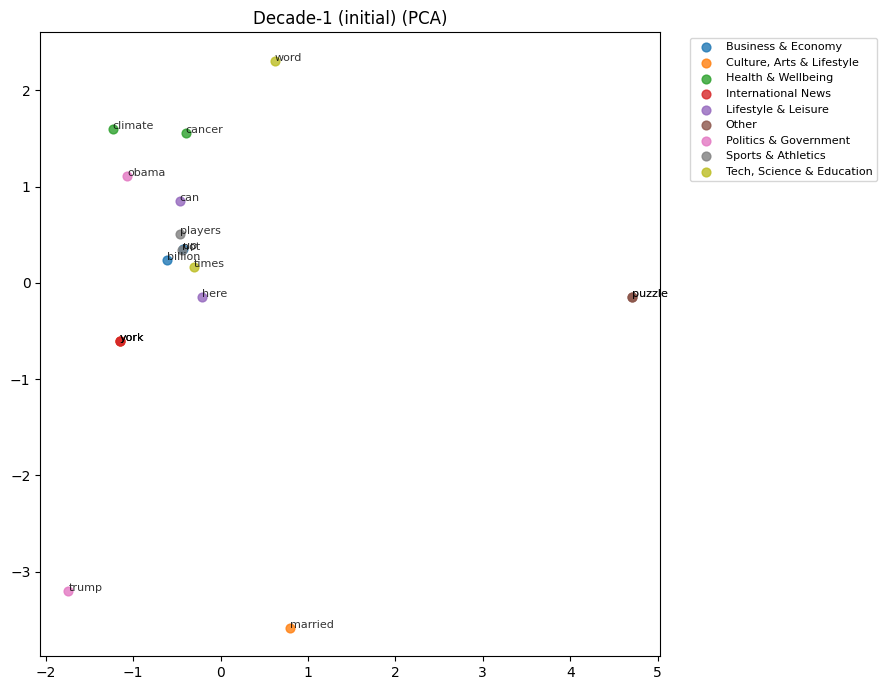

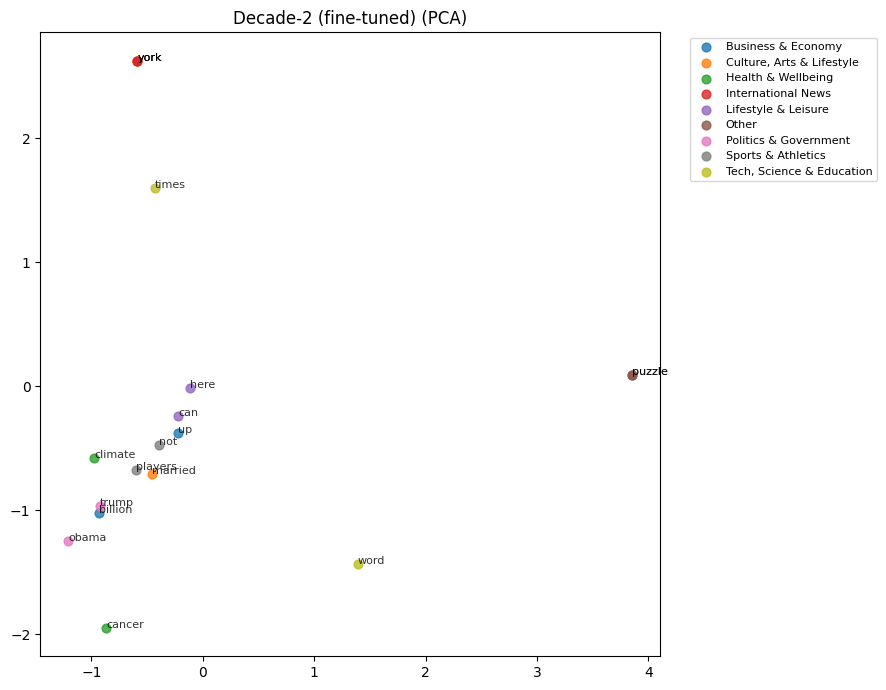

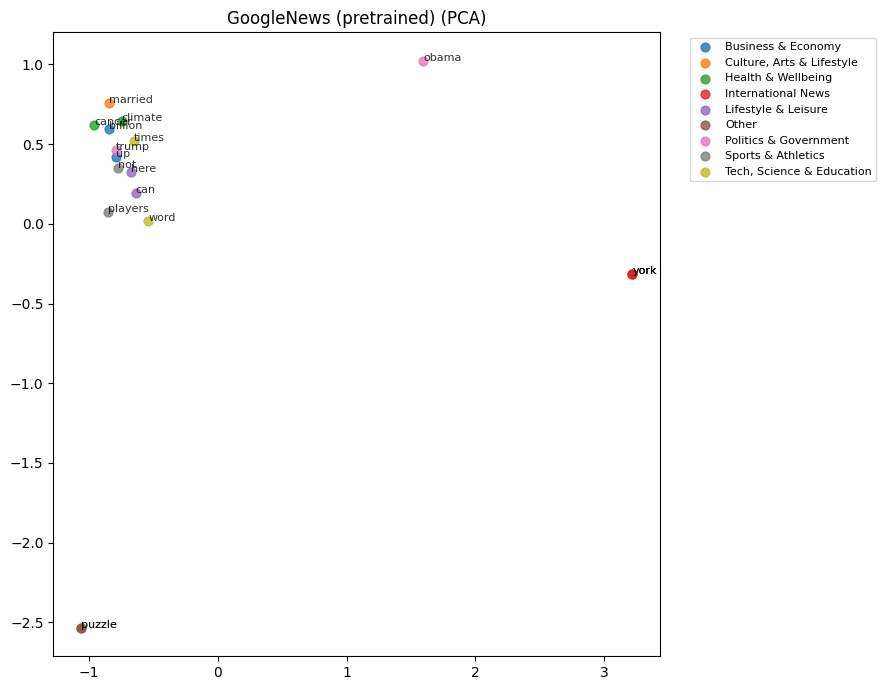

In [35]:
# === Flatten per-model matrices and 2D project with PCA/t-SNE/UMAP ===
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

def proj2d(X, method="pca", random_state=42):
    if method == "pca":
        return PCA(n_components=2, random_state=random_state).fit_transform(X)
    elif method == "tsne":
        return TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=min(30, max(5, len(X)//4)),
                    random_state=random_state).fit_transform(X)
    elif method == "umap":
        return umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.1, random_state=random_state).fit_transform(X)
    else:
        raise ValueError("method ∈ {pca, tsne, umap}")

def make_plot(df, vec_col, title, method="pca"):
    df_ = df.dropna(subset=[vec_col]).copy()
    if len(df_) == 0:
        print(f"No vectors for {vec_col}")
        return
    X = np.stack(df_[vec_col].to_numpy())
    Z = proj2d(X, method=method)
    df_["x"] = Z[:,0]; df_["y"] = Z[:,1]

    plt.figure(figsize=(9,7))
    for cat in sorted(df_["category"].unique()):
        sub = df_[df_["category"] == cat]
        plt.scatter(sub["x"], sub["y"], s=40, label=cat, alpha=0.8)
    for _, r in df_.iterrows():
        plt.text(r["x"], r["y"], r["word"], fontsize=8, alpha=0.8)
    plt.title(f"{title} ({method.upper()})")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=8)
    plt.tight_layout()
    plt.show()

# Choose projection once (justify in report). PCA is fast/stable; add TSNE/UMAP for non-linear view.
PROJ = "pca"   # or "tsne" / "umap"

make_plot(vecs, "v_d1",    "Decade-1 (initial)", method=PROJ)
make_plot(vecs, "v_d2",    "Decade-2 (fine-tuned)", method=PROJ)
make_plot(vecs, "v_gnews", "GoogleNews (pretrained)", method=PROJ)


In [38]:
# Part 2.3 - Extra Plots

# If you already loaded these earlier, you can skip this cell.
!pip -q install gensim==4.3.2 umap-learn

from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import gensim.downloader as api
from gensim.models import Word2Vec

OUT_P1 = Path("/content/ir_outputs/part1")
OUT_P2 = Path("/content/ir_outputs/part2")
FIG_DIR = OUT_P2 / "figs"; FIG_DIR.mkdir(parents=True, exist_ok=True)

# paths
WORDS_D1 = OUT_P1 / "words_decade1.txt"
WORDS_D2 = OUT_P1 / "words_decade2.txt"
MODEL_D1 = OUT_P2 / "w2vec_decade1.model"
MODEL_D2 = OUT_P2 / "w2vec_decade2_finetuned.model"

assert WORDS_D1.exists() and WORDS_D2.exists(), "Missing word lists."
assert MODEL_D1.exists() and MODEL_D2.exists(), "Missing trained models."

# load models
m_d1 = Word2Vec.load(str(MODEL_D1))
m_d2 = Word2Vec.load(str(MODEL_D2))





In [39]:
import math
from collections import defaultdict
from numpy.linalg import norm

def load_word_table(p: Path, tag: str):
    rows = []
    for line in p.read_text(encoding="utf-8").splitlines():
        parts = line.strip().split("\t")
        if len(parts) >= 2:
            rows.append({"category": parts[0], "word": parts[1], "origin": tag})
    return pd.DataFrame(rows)

w1 = load_word_table(WORDS_D1, "decade1")
w2 = load_word_table(WORDS_D2, "decade2")
words_all = pd.concat([w1, w2], ignore_index=True).drop_duplicates()

def try_vec(model_or_kv, tok):
    try:
        return (model_or_kv.wv[tok] if hasattr(model_or_kv, "wv") else model_or_kv[tok]).astype(np.float32)
    except KeyError:
        return None

# make a tall table: each (word, category) replicated per model that has it
def collect_all_points(df_words):
    rows = []
    for _, r in df_words.iterrows():
        cat, w = r["category"], r["word"]
        v_d1 = try_vec(m_d1, w)
        v_d2 = try_vec(m_d2, w)
        v_gn = try_vec(kv_gnews, w)
        for model, vec in [("D1", v_d1), ("D2", v_d2), ("GN", v_gn)]:
            if vec is not None:
                rows.append({"category":cat, "word":w, "model":model, "vec":vec})
    return pd.DataFrame(rows)

points = collect_all_points(words_all)

# projection helpers
def project_joint(points_df, method="pca", random_state=42):
    M = np.stack(points_df["vec"].to_numpy())
    if method == "pca":
        proj = PCA(n_components=2, random_state=random_state).fit_transform(M)
    elif method == "tsne":
        perplex = max(5, min(30, len(M)//4))
        proj = TSNE(n_components=2, init="pca", learning_rate="auto",
                    perplexity=perplex, random_state=random_state).fit_transform(M)
    elif method == "umap":
        proj = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.1,
                         random_state=random_state).fit_transform(M)
    else:
        raise ValueError("method must be 'pca', 'tsne', or 'umap'")
    df = points_df.copy()
    df["x"], df["y"] = proj[:,0], proj[:,1]
    return df

# stable color palette per category
def category_colors(categories):
    cmap = plt.get_cmap("tab20")
    cats = sorted(categories)
    color_map = {c: cmap(i % 20) for i, c in enumerate(cats)}
    return color_map

# cosine distance (for edge thickness)
def cosine_distance(a, b):
    if a is None or b is None: return None
    return 1.0 - float(np.dot(a, b) / (norm(a)*norm(b) + 1e-9))


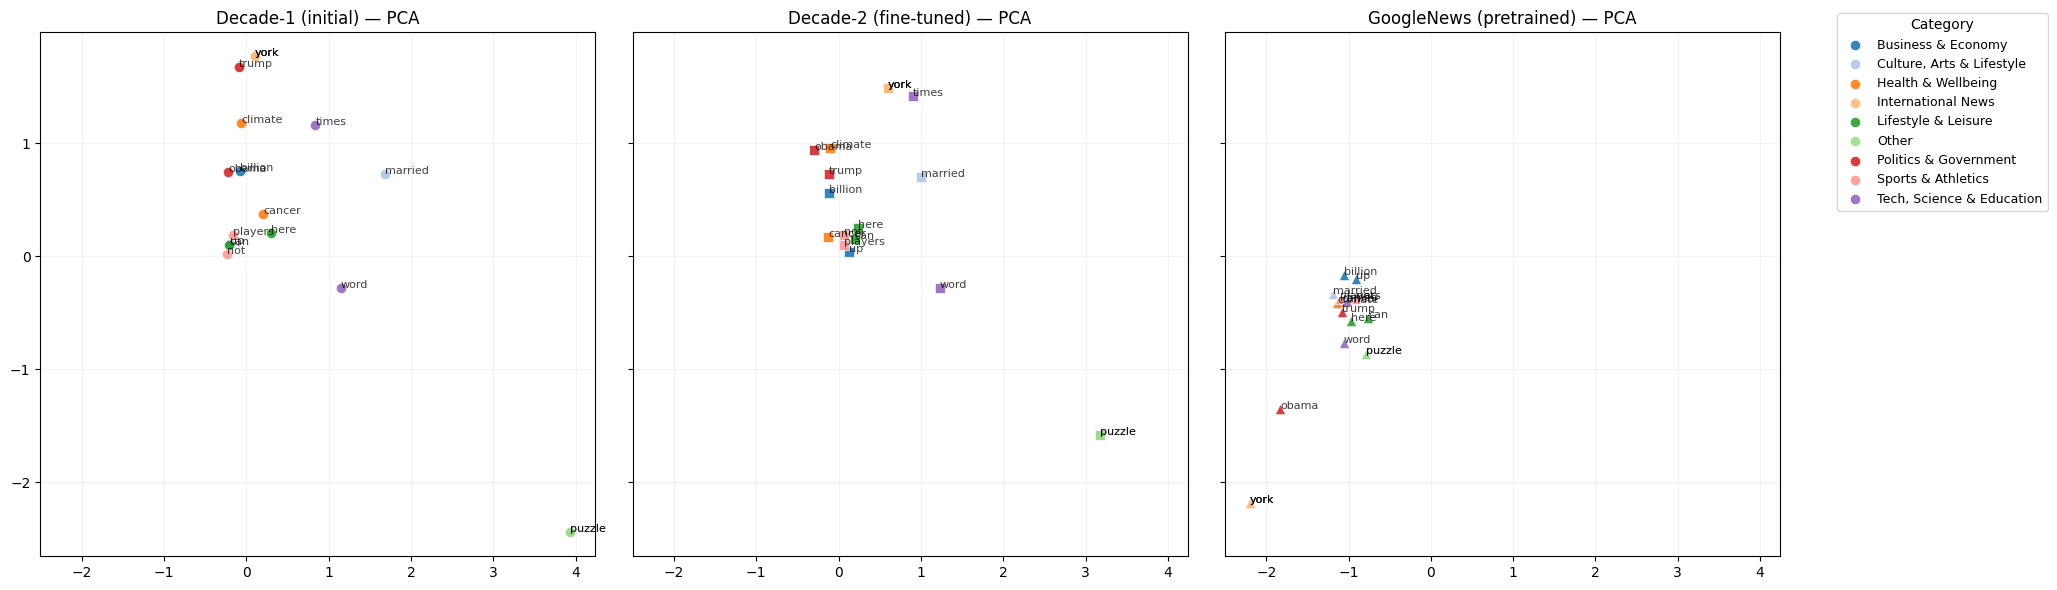

Saved: /content/ir_outputs/part2/figs/part2_3_small_multiples_pca.png


In [40]:
PROJ_METHOD = "pca"   # choose: "pca" (fast, stable), "tsne" (local), or "umap" (local + global balance)

proj_df = project_joint(points, method=PROJ_METHOD)
cat2color = category_colors(proj_df["category"].unique())

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
titles = {"D1": "Decade-1 (initial)", "D2": "Decade-2 (fine-tuned)", "GN": "GoogleNews (pretrained)"}
markers = {"D1": "o", "D2": "s", "GN": "^"}

for ax, model in zip(axs, ["D1","D2","GN"]):
    sub = proj_df[proj_df["model"] == model]
    for cat, g in sub.groupby("category"):
        ax.scatter(g["x"], g["y"], s=55, marker=markers[model],
                   color=cat2color[cat], edgecolors="white", linewidths=0.5, alpha=0.9, label=cat)
    # thin labels to avoid clutter: label only words that appear in >=2 models
    multi = proj_df.groupby("word")["model"].nunique()
    labelable = set(multi[multi >= 2].index)
    for _, r in sub[sub["word"].isin(labelable)].iterrows():
        ax.text(r["x"], r["y"], r["word"], fontsize=8, alpha=0.75)
    ax.set_title(f"{titles[model]} — {PROJ_METHOD.upper()}")
    ax.grid(True, alpha=0.15)

# one legend on the right
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.98), loc="upper left", title="Category", fontsize=9)
plt.tight_layout()
plt.savefig(FIG_DIR / f"part2_3_small_multiples_{PROJ_METHOD}.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", FIG_DIR / f"part2_3_small_multiples_{PROJ_METHOD}.png")


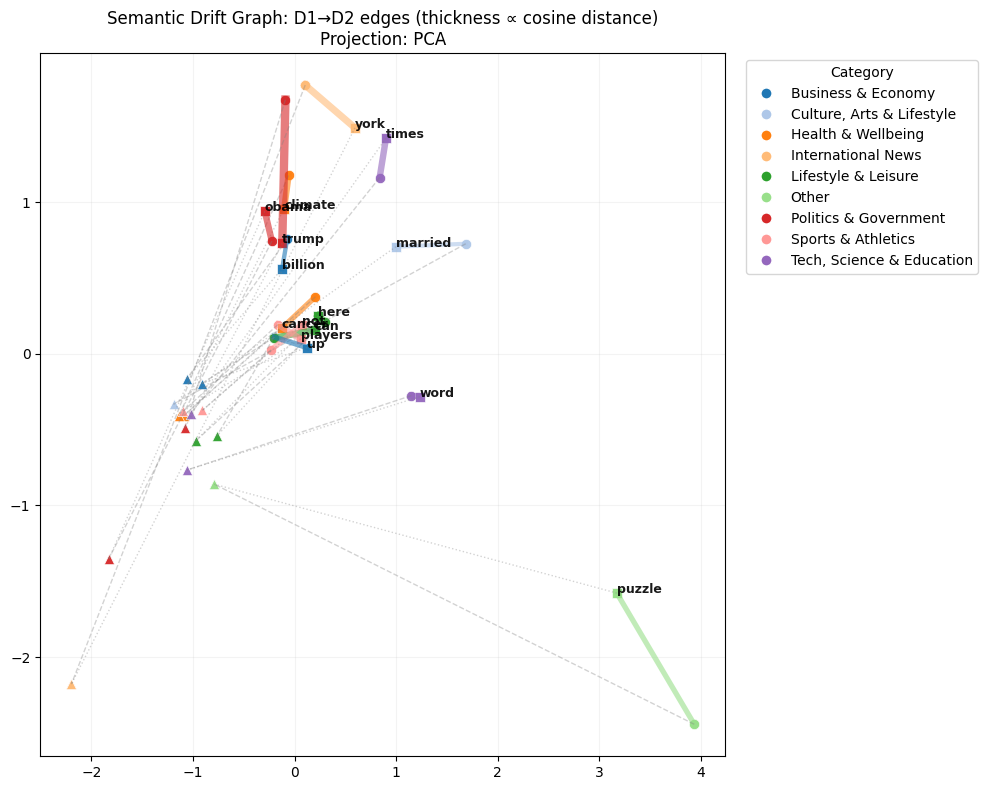

Saved: /content/ir_outputs/part2/figs/part2_3_drift_graph_pca.png
Avg cosine distance D1→D2 by category (higher = more drift):


,avg_drift
category,
Politics & Government,0.5722
International News,0.4501
Lifestyle & Leisure,0.4453
"Tech, Science & Education",0.4004
Health & Wellbeing,0.3749
Sports & Athletics,0.3712
Other,0.3322
Business & Economy,0.3009
"Culture, Arts & Lifestyle",0.2524


In [41]:
# index by (word, model) for quick lookup
idx = {(r["word"], r["model"]): (r["x"], r["y"]) for _, r in proj_df.iterrows()}
vec_index = {(r["word"], r["model"]): r["vec"] for _, r in proj_df.iterrows()}
markers = {"D1": "o", "D2": "s", "GN": "^"}

# compute per-word drift magnitudes (in original embedding space)
drifts = []
for w in sorted(proj_df["word"].unique()):
    v1 = vec_index.get((w,"D1")); v2 = vec_index.get((w,"D2")); vg = vec_index.get((w,"GN"))
    d12 = cosine_distance(v1, v2) if (v1 is not None and v2 is not None) else None
    d1g = cosine_distance(v1, vg) if (v1 is not None and vg is not None) else None
    d2g = cosine_distance(v2, vg) if (v2 is not None and vg is not None) else None
    # category (use any available row)
    cat = proj_df[proj_df["word"]==w]["category"].iloc[0]
    drifts.append({"word": w, "category": cat, "d12": d12, "d1g": d1g, "d2g": d2g})
drift_df = pd.DataFrame(drifts)

# normalize thickness for plotting (based on 95th percentile to reduce outlier dominance)
def thickness(values, min_w=0.5, max_w=6.0):
    arr = np.array([v for v in values if v is not None and not np.isnan(v)])
    if len(arr) == 0: return lambda v: 0.0
    cap = np.quantile(arr, 0.95)
    def mapw(v):
        if v is None or math.isnan(v): return 0.0
        x = min(v, cap) / (cap + 1e-9)
        return min_w + x*(max_w - min_w)
    return mapw

w12 = thickness(drift_df["d12"])  # D1→D2 widths

# Plot
plt.figure(figsize=(10, 8))
# draw edges first
for _, row in drift_df.iterrows():
    w, cat = row["word"], row["category"]
    # get 2D coordinates if present
    p1 = idx.get((w,"D1")); p2 = idx.get((w,"D2")); pg = idx.get((w,"GN"))
    # D1→D2: category color, thickness ∝ distance
    if p1 and p2 and row["d12"] is not None:
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]],
                 color=cat2color[cat], linewidth=w12(row["d12"]), alpha=0.6)
    # D1→GN: dashed gray
    if p1 and pg and row["d1g"] is not None:
        plt.plot([p1[0], pg[0]], [p1[1], pg[1]],
                 color="gray", linewidth=1.0, alpha=0.35, linestyle="--")
    # D2→GN: dotted gray
    if p2 and pg and row["d2g"] is not None:
        plt.plot([p2[0], pg[0]], [p2[1], pg[1]],
                 color="gray", linewidth=1.0, alpha=0.35, linestyle=":")

# nodes
for model, mk in markers.items():
    sub = proj_df[proj_df["model"] == model]
    for cat, g in sub.groupby("category"):
        plt.scatter(g["x"], g["y"], s=55, marker=mk, color=cat2color[cat],
                    edgecolors="white", linewidths=0.5, alpha=0.95, label=f"{cat} ({model})")

# label only the biggest drifts (top N by d12)
topN = 15
label_words = drift_df.sort_values("d12", ascending=False).dropna(subset=["d12"]).head(topN)["word"].tolist()
for w in label_words:
    # prefer D2 label pos; fallback D1
    pos = idx.get((w,"D2"), idx.get((w,"D1"), None))
    if pos:
        plt.text(pos[0], pos[1], w, fontsize=9, weight="bold", alpha=0.9)

plt.title(f"Semantic Drift Graph: D1→D2 edges (thickness ∝ cosine distance)\nProjection: {PROJ_METHOD.upper()}")
plt.grid(True, alpha=0.15)
# compact legend: categories only
handles = [plt.Line2D([0],[0], marker='o', color='w', label=cat,
           markerfacecolor=cat2color[cat], markersize=8) for cat in sorted(cat2color)]
plt.legend(handles=handles, title="Category", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
out_path = FIG_DIR / f"part2_3_drift_graph_{PROJ_METHOD}.png"
plt.savefig(out_path, dpi=220, bbox_inches="tight")
plt.show()

print("Saved:", out_path)

# quick drift summary per category (for your writeup)
summary = drift_df.groupby("category")["d12"].mean().sort_values(ascending=False)
print("Avg cosine distance D1→D2 by category (higher = more drift):")
display(summary.round(4).to_frame("avg_drift"))


# Part 3: Retrieval Task

In [49]:
nf = pd.read_csv(NF_PATH)
nf.head()

,query_id,doc_id,query,doc,relevance,query_clean,doc_clean,relevance_binary
0,PLAIN-3,MED-2436,breast cancer cells feed on cholesterol one in...,content low density lipoprotein receptors brea...,3,breast cancer cells feed on cholesterol one in...,content low density lipoprotein receptors brea...,1
1,PLAIN-3,MED-2437,breast cancer cells feed on cholesterol one in...,diet breast cancer understanding risks benefit...,3,breast cancer cells feed on cholesterol one in...,diet breast cancer understanding risks benefit...,1
2,PLAIN-3,MED-2438,breast cancer cells feed on cholesterol one in...,association dietary lignans phytoestrogen-rich...,3,breast cancer cells feed on cholesterol one in...,association dietary lignans phytoestrogen rich...,1
3,PLAIN-3,MED-2439,breast cancer cells feed on cholesterol one in...,plant sterols anticancer nutrients evidence ro...,3,breast cancer cells feed on cholesterol one in...,plant sterols anticancer nutrients evidence ro...,1
4,PLAIN-3,MED-2440,breast cancer cells feed on cholesterol one in...,total cholesterol cancer risk large prospectiv...,3,breast cancer cells feed on cholesterol one in...,total cholesterol cancer risk large prospectiv...,1


In [61]:
!pip -q install gensim==4.3.2 tqdm

from pathlib import Path
import json, numpy as np, pandas as pd
from tqdm.auto import tqdm
from gensim.models import Word2Vec
import gensim.downloader as api

# Paths
OUT_P1 = Path("/content/ir_outputs/part1")
OUT_P2 = Path("/content/ir_outputs/part2")
OUT_P3 = Path("/content/ir_outputs/part3"); OUT_P3.mkdir(parents=True, exist_ok=True)

NF_PATH = OUT_P1 / "nfcorpus_preprocessed.csv"
nf = pd.read_csv(NF_PATH)
print("NFCorpus shape:", nf.shape)
print("Columns:", list(nf.columns))

# Fixed to your dataset
q_id, d_id   = "query_id", "doc_id"
qclean, dclean = "query_clean", "doc_clean"
assert {q_id, d_id, qclean, dclean, "relevance_binary"}.issubset(nf.columns)

# Choose model variant
MODEL_CHOICE = "d2"   # "d1" or "gnews" also OK
MODEL_D1 = OUT_P2 / "w2vec_decade1.model"
MODEL_D2 = OUT_P2 / "w2vec_decade2_finetuned.model"

if MODEL_CHOICE == "d1":
    kv = Word2Vec.load(str(MODEL_D1)).wv
elif MODEL_CHOICE == "d2":
    kv = Word2Vec.load(str(MODEL_D2)).wv
elif MODEL_CHOICE == "gnews":
    kv = api.load("word2vec-google-news-300")  # big but cached after first use
else:
    raise ValueError("MODEL_CHOICE must be one of: 'd1','d2','gnews'")

EMB_DIM = int(kv.vector_size)
print("Using model:", MODEL_CHOICE, "| dim:", EMB_DIM)


NFCorpus shape: (165290, 8)
Columns: ['query_id', 'doc_id', 'query', 'doc', 'relevance', 'query_clean', 'doc_clean', 'relevance_binary']
Using model: d2 | dim: 300


In [62]:
# Fast membership set for vocab lookups
VOCAB = kv.key_to_index  # dict-like

def avg_embed_tokens(tokens):
    """
    tokens: list[str] from the *clean* columns (`*_clean`).
    Returns: np.ndarray (EMB_DIM, ) or None if no in-vocab token.
    """
    in_vocab = [t for t in tokens if t in VOCAB]
    if not in_vocab:
        return None
    # stack and mean (float32)
    V = np.vstack([kv[t] for t in in_vocab]).astype(np.float32, copy=False)
    return V.mean(axis=0)

def embed_unique_series(id_series: pd.Series, text_series: pd.Series, kind: str, sanity_n: int | None = None):
    """
    Embed each unique ID once.
    - id_series: e.g., nf['doc_id'] or nf['query_id']
    - text_series: e.g., nf['doc_clean'] or nf['query_clean']
    - kind: 'doc' or 'qry' (used for filenames)
    - sanity_n: if set (e.g., 5), only process first N unique IDs for a sanity check
    Returns:
      ids: list of unique IDs in the order embedded
      M:   np.ndarray shape (N, EMB_DIM) with NaN rows for skipped
      skipped_idx: indices (in 0..N-1) that were None/NaN
    """
    # Build a mapping id -> first clean text (dedupe)
    dfu = pd.DataFrame({ "id": id_series, "text": text_series }).dropna().drop_duplicates("id", keep="first")
    if sanity_n is not None:
        dfu = dfu.head(sanity_n).copy()

    ids = dfu["id"].tolist()
    texts = dfu["text"].astype(str).tolist()

    M = np.full((len(ids), EMB_DIM), np.nan, dtype=np.float32)
    skipped_idx = []

    for i, txt in enumerate(tqdm(texts, desc=f"Embedding unique {kind}s", leave=False)):
        # text is already clean; just split to tokens
        toks = txt.split()
        v = avg_embed_tokens(toks)
        if v is None:
            skipped_idx.append(i)
        else:
            M[i] = v

    # Save arrays + metadata
    prefix = OUT_P3 / f"{kind}_emb_{MODEL_CHOICE}"
    if sanity_n is None:
        np.save(f"{prefix}.npy", M)
        Path(f"{prefix}_ids.json").write_text(json.dumps(ids, indent=2))
        Path(f"{prefix}_none.json").write_text(json.dumps(
            {"none_idx": skipped_idx, "count_none": len(skipped_idx), "total": len(ids)}, indent=2
        ))
        print(f"Saved {kind} embeddings -> {prefix}.npy")
        print(f"Saved {kind} id list   -> {prefix}_ids.json")
        print(f"Saved {kind} None meta -> {prefix}_none.json")

    return ids, M, skipped_idx


In [63]:
# A quick dry run on a handful of unique docs & queries
doc_ids_s, doc_M_s, doc_skipped_s = embed_unique_series(nf[d_id], nf[dclean], kind="doc", sanity_n=8)
qry_ids_s, qry_M_s, qry_skipped_s = embed_unique_series(nf[q_id], nf[qclean], kind="qry", sanity_n=8)

print(f"[SANITY] Docs: embedded {len(doc_ids_s)} | skipped {len(doc_skipped_s)}")
print(f"[SANITY] Qrys: embedded {len(qry_ids_s)} | skipped {len(qry_skipped_s)}")
print("Sample doc vec row 0:", doc_M_s[0][:6])
print("Sample qry vec row 0:", qry_M_s[0][:6])


Embedding unique docs:   0%|          | 0/8 [00:00<?, ?it/s]

Embedding unique qrys:   0%|          | 0/8 [00:00<?, ?it/s]

[SANITY] Docs: embedded 8 | skipped 0
[SANITY] Qrys: embedded 8 | skipped 0
Sample doc vec row 0: [-0.14779423 -0.11073682 -0.07926087 -0.02481414  0.02260736 -0.10614058]
Sample qry vec row 0: [-0.04580187 -0.07948743 -0.09469517  0.02862098 -0.05832878  0.00216031]


In [64]:
# Full unique embedding pass (this is the expensive part; but done once)
doc_ids, doc_M, doc_skipped = embed_unique_series(nf[d_id], nf[dclean], kind="doc", sanity_n=None)
qry_ids, qry_M, qry_skipped = embed_unique_series(nf[q_id], nf[qclean], kind="qry", sanity_n=None)

print(f"[FULL] Unique docs embedded: {len(doc_ids)} | skipped {len(doc_skipped)}")
print(f"[FULL] Unique qrys embedded: {len(qry_ids)} | skipped {len(qry_skipped)}")


Embedding unique docs:   0%|          | 0/3612 [00:00<?, ?it/s]

Saved doc embeddings -> /content/ir_outputs/part3/doc_emb_d2.npy
Saved doc id list   -> /content/ir_outputs/part3/doc_emb_d2_ids.json
Saved doc None meta -> /content/ir_outputs/part3/doc_emb_d2_none.json


Embedding unique qrys:   0%|          | 0/2594 [00:00<?, ?it/s]

Saved qry embeddings -> /content/ir_outputs/part3/qry_emb_d2.npy
Saved qry id list   -> /content/ir_outputs/part3/qry_emb_d2_ids.json
Saved qry None meta -> /content/ir_outputs/part3/qry_emb_d2_none.json
[FULL] Unique docs embedded: 3612 | skipped 0
[FULL] Unique qrys embedded: 2594 | skipped 0


In [65]:
# Build id->row maps (for quick lookup later)
docid_to_row = {idv: i for i, idv in enumerate(doc_ids)}
qryd_to_row  = {idv: i for i, idv in enumerate(qry_ids)}

# Save for reuse
Path(OUT_P3 / f"docid_to_row_{MODEL_CHOICE}.json").write_text(json.dumps(docid_to_row))
Path(OUT_P3 / f"qryd_to_row_{MODEL_CHOICE}.json").write_text(json.dumps(qryd_to_row))
print("Saved id->row maps.")


Saved id->row maps.


In [66]:
rep = f"""
Part 3.1 — Efficient Embedding (dedup by IDs)
=============================================
Model           : {MODEL_CHOICE}
Embedding dim   : {EMB_DIM}

Unique docs     : {len(doc_ids)}
Skipped docs    : {len(doc_skipped)}  (NaN rows in .npy)
Unique queries  : {len(qry_ids)}
Skipped queries : {len(qry_skipped)}  (NaN rows in .npy)

Artifacts:
- /content/ir_outputs/part3/doc_emb_{MODEL_CHOICE}.npy
- /content/ir_outputs/part3/doc_emb_{MODEL_CHOICE}_ids.json
- /content/ir_outputs/part3/doc_emb_{MODEL_CHOICE}_none.json
- /content/ir_outputs/part3/qry_emb_{MODEL_CHOICE}.npy
- /content/ir_outputs/part3/qry_emb_{MODEL_CHOICE}_ids.json
- /content/ir_outputs/part3/qry_emb_{MODEL_CHOICE}_none.json
- /content/ir_outputs/part3/docid_to_row_{MODEL_CHOICE}.json
- /content/ir_outputs/part3/qryd_to_row_{MODEL_CHOICE}.json
"""
(OUT_P3 / "part3.1_eff_report.txt").write_text(rep.strip()+"\n", encoding="utf-8")
print("Wrote:", OUT_P3 / "part3.1_eff_report.txt")


Wrote: /content/ir_outputs/part3/part3.1_eff_report.txt


## Part 3.2:

In [67]:
!pip -q install rank-bm25 scikit-learn

from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi

# Paths
OUT_P1 = Path("/content/ir_outputs/part1")
OUT_P3 = Path("/content/ir_outputs/part3"); OUT_P3.mkdir(parents=True, exist_ok=True)

# Load NFCorpus (preprocessed)
nf_path = OUT_P1 / "nfcorpus_preprocessed.csv"
nf = pd.read_csv(nf_path)
print("NFCorpus shape:", nf.shape)
print("Columns:", list(nf.columns))

# Fixed to your schema
q_id, d_id   = "query_id", "doc_id"
qclean, dclean = "query_clean", "doc_clean"

assert {q_id, d_id, qclean, dclean, "relevance_binary"}.issubset(nf.columns)

# Unique docs only (build indices over these)
docs_uni = nf[[d_id, dclean]].dropna().drop_duplicates(subset=[d_id], keep="first").reset_index(drop=True)
print("Unique docs:", len(docs_uni))

# id -> row mapping (for later lookups)
docid_to_row = {doc_id: i for i, doc_id in enumerate(docs_uni[d_id].tolist())}


NFCorpus shape: (165290, 8)
Columns: ['query_id', 'doc_id', 'query', 'doc', 'relevance', 'query_clean', 'doc_clean', 'relevance_binary']
Unique docs: 3612


In [68]:
# TF-IDF over doc_clean (already preprocessed)
tfidf = TfidfVectorizer(
    lowercase=False,                 # texts are already cleaned
    token_pattern=r"(?u)\b\w\w+\b",  # safe for our clean tokens
    ngram_range=(1,2),               # unigrams + bigrams often help
    min_df=2                         # ignore extremely rare terms
)
X_docs = tfidf.fit_transform(docs_uni[dclean].fillna(""))

print("TF-IDF matrix shape:", X_docs.shape)


TF-IDF matrix shape: (3612, 60548)


In [69]:
# Token lists from doc_clean (whitespace-separated tokens)
docs_tokens = [s.split() for s in docs_uni[dclean].fillna("").astype(str).tolist()]
bm25 = BM25Okapi(docs_tokens)
print("BM25 index built over", len(docs_tokens), "documents")


BM25 index built over 3612 documents


In [70]:
def tfidf_cosine_single(query_clean_text: str, doc_row: int) -> float:
    """
    Cosine(tfidf(query), tfidf(doc_row))
    """
    qv = tfidf.transform([query_clean_text])    # 1 x V
    dv = X_docs[doc_row]                        # 1 x V (sparse row)
    return float(cosine_similarity(qv, dv)[0, 0])

def tfidf_cosine_batch(query_clean_text: str, doc_rows: np.ndarray) -> np.ndarray:
    """
    Vectorized cosine against many doc rows (e.g., K candidates).
    Returns array of shape (len(doc_rows),)
    """
    qv = tfidf.transform([query_clean_text])     # 1 x V
    D  = X_docs[doc_rows]                        # K x V (sparse)
    sims = cosine_similarity(qv, D)              # 1 x K
    return sims.ravel()

def bm25_score_single(query_clean_text: str, doc_row: int) -> float:
    """
    BM25 score for (query, doc_row)
    """
    q_tokens = query_clean_text.split()
    return float(bm25.get_scores(q_tokens)[doc_row])

def bm25_score_batch(query_clean_text: str, doc_rows: np.ndarray | None = None) -> np.ndarray:
    """
    BM25 scores for a query on either the whole index (doc_rows=None) or a subset.
    Returns a 1D array of scores aligned with doc_rows if provided, else full array.
    """
    q_tokens = query_clean_text.split()
    s_all = bm25.get_scores(q_tokens)
    if doc_rows is None:
        return s_all
    return np.asarray(s_all)[doc_rows]


In [71]:
# Pick a random query row from nf, and a few random documents to score
sample_q = nf[qclean].dropna().astype(str).iloc[0]
sample_doc_rows = np.random.choice(len(docs_uni), size=5, replace=False)

s_t = tfidf_cosine_batch(sample_q, sample_doc_rows)
s_b = bm25_score_batch(sample_q, sample_doc_rows)

print("Sample query:", sample_q[:120], "...")
print("Doc rows:", sample_doc_rows)
print("TF-IDF cosines:", np.round(s_t, 4))
print("BM25 scores   :", np.round(s_b, 4))


Sample query: breast cancer cells feed on cholesterol one in eight american women will be diagnosed with breast cancer in her lifetime ...
Doc rows: [ 776  452 1439 1314 3180]
TF-IDF cosines: [0.004  0.0033 0.0121 0.0565 0.0522]
BM25 scores   : [ 64.0473  54.3985 255.5588 661.1548 709.2805]


In [72]:
import joblib, scipy.sparse

joblib.dump(tfidf, OUT_P3 / "tfidf_vectorizer.joblib")
scipy.sparse.save_npz(OUT_P3 / "tfidf_docs.npz", X_docs)
pd.Series(docs_uni[d_id].tolist()).to_csv(OUT_P3 / "doc_ids_tfidf_index.csv", index=False, header=False)

# BM25 is quick to rebuild; if you want to persist token lists:
pd.Series([" ".join(toks) for toks in docs_tokens]).to_csv(OUT_P3 / "bm25_docs_tokens.txt", index=False, header=False)

print("Saved TF-IDF vectorizer/matrix and doc ids (and BM25 tokens).")


Saved TF-IDF vectorizer/matrix and doc ids (and BM25 tokens).


## Part 3.3

In [73]:
# === Config: pick the same model tag you used in 3.1 when saving embeddings ===
from pathlib import Path
import json, numpy as np, pandas as pd
from numpy.linalg import norm

OUT_P3 = Path("/content/ir_outputs/part3")

MODEL_TAG = "d2"   # "d1" or "gnews" if you saved those variants

# Load de-duplicated embeddings & ID lists
qry_M = np.load(OUT_P3 / f"qry_emb_{MODEL_TAG}.npy")
doc_M = np.load(OUT_P3 / f"doc_emb_{MODEL_TAG}.npy")

qry_ids = json.loads((OUT_P3 / f"qry_emb_{MODEL_TAG}_ids.json").read_text())
doc_ids = json.loads((OUT_P3 / f"doc_emb_{MODEL_TAG}_ids.json").read_text())

# Build ID -> row maps
qryid_to_row = {qid: i for i, qid in enumerate(qry_ids)}
docid_to_row = {did: i for i, did in enumerate(doc_ids)}

# Helper: safe cosine that returns np.nan if either vector is NaN row
def _cos_safe(u: np.ndarray, v: np.ndarray) -> float:
    if u is None or v is None:
        return np.nan
    if np.isnan(u).any() or np.isnan(v).any():
        return np.nan
    return float(np.dot(u, v) / (norm(u) * norm(v) + 1e-9))

def semb_single(qry_id, doc_id) -> float:
    """
    Return cosine(emb(query_id), emb(doc_id)).
    If either side was skipped (NaN row), returns np.nan.
    """
    qi = qryid_to_row.get(qry_id, None)
    di = docid_to_row.get(doc_id, None)
    if qi is None or di is None:
        return np.nan
    return _cos_safe(qry_M[qi], doc_M[di])

def semb_batch_qid_rows(qry_id, doc_rows: np.ndarray) -> np.ndarray:
    """
    Vectorized cosine for a single query ID against many document *rows*.
    (Use this after BM25 candidate gen where you have doc rows.)
    Returns an array of shape (len(doc_rows),) with np.nan for missing vectors.
    """
    qi = qryid_to_row.get(qry_id, None)
    if qi is None or np.isnan(qry_M[qi]).any():
        return np.full(len(doc_rows), np.nan, dtype=np.float32)

    qv = qry_M[qi]
    D = doc_M[doc_rows]   # (K, dim)
    # mask out invalid doc rows (NaN rows)
    mask = ~np.any(np.isnan(D), axis=1)
    out = np.full(len(doc_rows), np.nan, dtype=np.float32)
    if mask.any():
        Dv = D[mask]
        denom = (norm(qv) * np.linalg.norm(Dv, axis=1) + 1e-9)
        out[mask] = (Dv @ qv) / denom
    return out

# (Optional) Batch scoring by direct doc_ids instead of rows
def semb_batch_qid_docids(qry_id, doc_id_list: list) -> np.ndarray:
    rows = np.array([docid_to_row.get(did, -1) for did in doc_id_list], dtype=int)
    valid = rows >= 0
    out = np.full(len(doc_id_list), np.nan, dtype=np.float32)
    if valid.any():
        out[valid] = semb_batch_qid_rows(qry_id, rows[valid])
    return out


In [74]:
# Example: pick any query_id and a few doc_ids that you know exist

from pathlib import Path
import pandas as pd

nf = pd.read_csv("/content/ir_outputs/part1/nfcorpus_preprocessed.csv")

q_id_col, d_id_col = "query_id", "doc_id"
some_row = nf.sample(1, random_state=7).iloc[0]
qid = some_row[q_id_col]
# grab BM25 top-5 to test later; for now just take a few doc_ids from the same query block
doc_ids_sample = nf[nf[q_id_col]==qid][d_id_col].drop_duplicates().head(5).tolist()

print("Query ID:", qid)
print("Doc IDs:", doc_ids_sample)

# Single pair
print("semb_single:", semb_single(qid, doc_ids_sample[0]))

# Batch by IDs
print("semb_batch:", semb_batch_qid_docids(qid, doc_ids_sample))


Query ID: PLAIN-2088
Doc IDs: ['MED-4399', 'MED-4400', 'MED-4402', 'MED-2182', 'MED-2464']
semb_single: 0.8374117612838745
semb_batch: [0.83741176 0.7610379  0.8338352  0.672187   0.8167979 ]


## 3.4:

In [75]:
import numpy as np

def _minmax_per_query(x: np.ndarray) -> np.ndarray:
    """
    Per-query min–max for one score vector over the current candidate set.
    - x: shape (K,)
    Returns: shape (K,), scaled to [0,1]; NaNs -> 0; constant vectors -> 0s.
    """
    x = np.asarray(x, dtype=float)
    # mask valid
    m = ~np.isnan(x)
    if not m.any():
        return np.zeros_like(x, dtype=float)
    xmin, xmax = np.min(x[m]), np.max(x[m])
    if xmax - xmin <= 1e-12:
        out = np.zeros_like(x, dtype=float)   # all equal → no discrimination
    else:
        out = np.zeros_like(x, dtype=float)
        out[m] = (x[m] - xmin) / (xmax - xmin)
    # any NaN becomes 0 after scaling
    out[~m] = 0.0
    # clip numerical noise
    return np.clip(out, 0.0, 1.0)

def fuse_scores_per_query(
    s_tfidf: np.ndarray,
    s_bm25:  np.ndarray,
    s_emb:   np.ndarray,
    alpha: float = 0.3,
    beta:  float = 0.4,
    gamma: float = 0.3,
    return_components: bool = False,
):
    """
    Normalize each score vector to [0,1] over the candidate set and fuse:
    S = alpha*tfidf + beta*bm25 + gamma*emb
    - Inputs are shape (K,) for this query's candidates (same order).
    - NaNs are allowed (e.g., missing embeddings); they are treated as 0 after normalization.
    - Weights should sum to 1 (you can enforce or just let them be).
    Returns:
      S (K,) and optionally a dict of normalized components.
    """
    # Normalize each component over candidates
    nt = _minmax_per_query(s_tfidf)
    nb = _minmax_per_query(s_bm25)
    ne = _minmax_per_query(s_emb)

    # Weighted fusion
    S = alpha * nt + beta * nb + gamma * ne

    if return_components:
        return S, {"tfidf": nt, "bm25": nb, "emb": ne}
    return S


## Part 3.5:

In [82]:
# =========================
# Hybrid IR Retrieval System (OOP)
# =========================
!pip -q install rank-bm25 scikit-learn gensim==4.3.2

from pathlib import Path
import json, numpy as np, pandas as pd
from numpy.linalg import norm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi
import joblib, scipy.sparse

# ---------- Utilities ----------
def _minmax_per_query(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    m = ~np.isnan(x)
    if not m.any():
        return np.zeros_like(x, dtype=float)
    lo, hi = np.min(x[m]), np.max(x[m])
    if hi - lo <= 1e-12:
        out = np.zeros_like(x, dtype=float)
    else:
        out = np.zeros_like(x, dtype=float)
        out[m] = (x[m] - lo) / (hi - lo)
    out[~m] = 0.0
    return np.clip(out, 0.0, 1.0)

def _cos_safe(u: np.ndarray, v: np.ndarray) -> float:
    if u is None or v is None:
        return np.nan
    if np.isnan(u).any() or np.isnan(v).any():
        return np.nan
    return float(np.dot(u, v) / (norm(u) * norm(v) + 1e-9))

# ---------- Resources holder ----------
class HybridResources:
    """
    Holds all indices and embeddings so multiple retrievers (different weights, K, model tag) can share them.
    """
    def __init__(
        self,
        nf_path="/content/ir_outputs/part1/nfcorpus_preprocessed.csv",
        out_p3="/content/ir_outputs/part3",
        model_tag="d2",  # "d1" | "d2" | "gnews"
        q_id_col="query_id", d_id_col="doc_id",
        q_clean_col="query_clean", d_clean_col="doc_clean",
    ):
        self.paths = {
            "nf": Path(nf_path),
            "p3": Path(out_p3),
            "tfidf_vec": Path(out_p3) / "tfidf_vectorizer.joblib",
            "tfidf_mtx": Path(out_p3) / "tfidf_docs.npz",
            "doc_ids_tfidf": Path(out_p3) / "doc_ids_tfidf_index.csv",
            "bm25_tokens": Path(out_p3) / "bm25_docs_tokens.txt",
            "qry_emb": Path(out_p3) / f"qry_emb_{model_tag}.npy",
            "qry_ids": Path(out_p3) / f"qry_emb_{model_tag}_ids.json",
            "doc_emb": Path(out_p3) / f"doc_emb_{model_tag}.npy",
            "doc_ids": Path(out_p3) / f"doc_emb_{model_tag}_ids.json",
            "docid_to_row": Path(out_p3) / f"docid_to_row_{model_tag}.json",
            "qryd_to_row": Path(out_p3) / f"qryd_to_row_{model_tag}.json",
        }
        self.model_tag = model_tag
        self.q_id_col, self.d_id_col = q_id_col, d_id_col
        self.q_clean_col, self.d_clean_col = q_clean_col, d_clean_col

        self.relbin_col='relevance_binary'
        self.rel_col='relevance'

        # Load NFCorpus
        self.nf = pd.read_csv(self.paths["nf"])
        # Load TF-IDF
        self.tfidf = joblib.load(self.paths["tfidf_vec"])
        self.X_docs = scipy.sparse.load_npz(self.paths["tfidf_mtx"])
        self.tfidf_doc_ids = pd.read_csv(self.paths["doc_ids_tfidf"], header=None)[0].tolist()

        # Build BM25 from token file (fast), or rebuild from nf if needed
        if self.paths["bm25_tokens"].exists():
            toks_lines = Path(self.paths["bm25_tokens"]).read_text(encoding="utf-8").splitlines()
            self.docs_tokens = [line.split() for line in toks_lines]
        else:
            # Fallback: rebuild from nf unique docs
            docs_uni = (self.nf[[self.d_id_col, self.d_clean_col]]
                        .dropna().drop_duplicates(subset=[self.d_id_col], keep="first")
                        .reset_index(drop=True))
            self.docs_tokens = [s.split() for s in docs_uni[self.d_clean_col].fillna("").astype(str)]
            # Note: you can also re-save bm25 tokens here if you want
        self.bm25 = BM25Okapi(self.docs_tokens)

        # Embeddings (dedup by IDs)
        self.qry_M = np.load(self.paths["qry_emb"])
        self.doc_M = np.load(self.paths["doc_emb"])
        self.qry_ids = json.loads(self.paths["qry_ids"].read_text())
        self.doc_ids = json.loads(self.paths["doc_ids"].read_text())

        # ID -> row maps for embeddings
        if self.paths["docid_to_row"].exists():
            self.docid_to_row = json.loads(self.paths["docid_to_row"].read_text())
        else:
            self.docid_to_row = {did: i for i, did in enumerate(self.doc_ids)}
        if self.paths["qryd_to_row"].exists():
            self.qryd_to_row = json.loads(self.paths["qryd_to_row"].read_text())
        else:
            self.qryd_to_row = {qid: i for i, qid in enumerate(self.qry_ids)}

        # Map from TF-IDF doc-row to doc_id (so we can return IDs)
        self.tfidf_row_to_docid = self.tfidf_doc_ids
        # And a reverse map (doc_id -> row in TF-IDF matrix)
        self.docid_to_tfidfrow = {doc_id: i for i, doc_id in enumerate(self.tfidf_doc_ids)}

    # ------- Scorers -------
    def tfidf_cosine_batch(self, query_clean_text: str, doc_rows: np.ndarray) -> np.ndarray:
        qv = self.tfidf.transform([query_clean_text])
        D = self.X_docs[doc_rows]
        sims = cosine_similarity(qv, D)
        return sims.ravel()

    def bm25_score_batch(self, query_clean_text: str, doc_rows: np.ndarray | None = None) -> np.ndarray:
        q_tokens = query_clean_text.split()
        s_all = self.bm25.get_scores(q_tokens)
        if doc_rows is None:
            return s_all
        return np.asarray(s_all)[doc_rows]

    def semb_batch_qid_rows(self, query_id, doc_rows: np.ndarray) -> np.ndarray:
        qi = self.qryd_to_row.get(str(query_id)) if str(query_id) in self.qryd_to_row else self.qryd_to_row.get(query_id)
        out = np.full(len(doc_rows), np.nan, dtype=np.float32)
        if qi is None:
            return out
        qv = self.qry_M[qi]
        if np.isnan(qv).any():
            return out
        D = self.doc_M[doc_rows]
        mask = ~np.any(np.isnan(D), axis=1)
        if mask.any():
            denom = (norm(qv) * np.linalg.norm(D[mask], axis=1) + 1e-9)
            out[mask] = (D[mask] @ qv) / denom
        return out

# ---------- Retriever ----------
class HybridRetriever:
    def __init__(self, resources: HybridResources, K=100, alpha=0.3, beta=0.4, gamma=0.3):
        assert abs(alpha + beta + gamma - 1.0) < 1e-9, "alpha+beta+gamma must sum to 1"
        self.R = resources
        self.K = int(K)
        self.alpha, self.beta, self.gamma = alpha, beta, gamma

    def candidate_gen(self, query_clean_text: str) -> np.ndarray:
        # BM25 over all docs; take top-K doc_rows (in the TF-IDF/BM25 index space)
        bm25_all = self.R.bm25_score_batch(query_clean_text, doc_rows=None)
        if self.K >= len(bm25_all):
            cand_rows = np.argsort(bm25_all)[::-1]
        else:
            cand_rows = np.argpartition(bm25_all, -self.K)[-self.K:]
            cand_rows = cand_rows[np.argsort(bm25_all[cand_rows])[::-1]]
        return cand_rows

    def rerank_fused(self, query_id, query_clean_text: str, cand_rows: np.ndarray, topn=10) -> pd.DataFrame:
        # 1) three score vectors on candidates
        s_b = self.R.bm25_score_batch(query_clean_text, cand_rows)                 # (K,)
        s_t = self.R.tfidf_cosine_batch(query_clean_text, cand_rows)              # (K,)
        s_e = self.R.semb_batch_qid_rows(query_id, cand_rows)                     # (K,) with NaNs possible

        # 2) per-query min-max normalization
        nt = _minmax_per_query(s_t)
        nb = _minmax_per_query(s_b)
        ne = _minmax_per_query(s_e)

        # 3) fusion
        S = self.alpha * nt + self.beta * nb + self.gamma * ne

        # 4) rank
        order = np.argsort(S)[::-1]
        keep = order[:topn]
        rows = cand_rows[keep]
        doc_ids = [self.R.tfidf_row_to_docid[r] for r in rows]

        # collect outputs
        df = pd.DataFrame({
            "rank": np.arange(1, len(keep)+1),
            "doc_row": rows,
            "doc_id": doc_ids,
            "S_fused": S[keep],
            "s_tfidf": s_t[keep], "s_tfidf_norm": nt[keep],
            "s_bm25":  s_b[keep], "s_bm25_norm":  nb[keep],
            "s_emb":   s_e[keep], "s_emb_norm":   ne[keep],
        })
        return df

    # --- Drop-in replacement for HybridRetriever.retrieve (adds labels) ---
    def retrieve(self, query_id, query_clean_text: str, topn=10):
        cand_rows = self.candidate_gen(query_clean_text)
        df = self.rerank_fused(query_id, query_clean_text, cand_rows, topn=topn)

        # Attach relevance labels for this query (per (query_id, doc_id))
        qmask = self.R.nf[self.R.q_id_col] == query_id
        cols = [self.R.d_id_col, self.R.q_id_col, self.R.relbin_col]
        if self.R.rel_col:
            cols.append(self.R.rel_col)
        qpairs = (self.R.nf.loc[qmask, cols]
                    .drop_duplicates(subset=[self.R.d_id_col], keep="first")
                    .set_index(self.R.d_id_col))

        df["relevance_binary"] = df["doc_id"].map(qpairs[self.R.relbin_col]).astype("Int64")
        if self.R.rel_col:
            df["relevance"] = df["doc_id"].map(qpairs[self.R.rel_col])

        # Optional: put labels up front
        front = ["rank","doc_id","relevance_binary"]
        if self.R.rel_col: front.append("relevance")
        ordered = front + [c for c in df.columns if c not in front]
        return df[ordered]



In [83]:
# Load resources (model_tag can be "d1", "d2", or "gnews" — it must match the saved embeddings)
RES = HybridResources(model_tag="d2")

# Build a retriever (tune weights/ K as you like)
RET = HybridRetriever(RES, K=100, alpha=0.3, beta=0.4, gamma=0.3)

# Pick a real query row
row = RES.nf.sample(1, random_state=13).iloc[0]
qid, qtext = row[RES.q_id_col], row[RES.q_clean_col]
print("Query ID:", qid)
print("Query clean:", qtext[:140], "...")

# Retrieve top-10
res_df = RET.retrieve(qid, qtext, topn=10)
res_df.head(10)


Query ID: PLAIN-676
Query clean: berries berries may be helpful in the prevention of chronic disease including cancer and heart disease fruits in general and berries in part ...


,rank,doc_id,relevance_binary,relevance,doc_row,S_fused,s_tfidf,s_tfidf_norm,s_bm25,s_bm25_norm,s_emb,s_emb_norm
0,1,MED-2924,1,2.0,394,0.924114,0.165400,1.000000,220.768837,0.896235,0.912614,0.885399
1,2,MED-4900,1,2.0,3492,0.886995,0.160125,0.962535,218.629415,0.877593,0.904130,0.823990
2,3,MED-2922,1,2.0,392,0.777988,0.103702,0.561830,221.782641,0.905068,0.904229,0.824706
3,4,MED-2951,1,2.0,1174,0.760757,0.090698,0.469480,232.677582,1.000000,0.891566,0.733043
4,5,MED-4689,1,2.0,640,0.760757,0.090698,0.469480,232.677582,1.000000,0.891566,0.733043
5,6,MED-1676,1,2.0,2422,0.690171,0.117123,0.657145,207.918509,0.784265,0.872873,0.597740
6,7,MED-2665,1,2.0,138,0.684078,0.105064,0.571503,191.396221,0.640301,0.908418,0.855022
7,8,MED-2507,<NA>,NaN,193,0.632201,0.063184,0.274076,197.170454,0.690614,0.916350,0.912443
8,9,MED-4591,<NA>,NaN,2374,0.616030,0.087646,0.447801,178.885845,0.531293,0.914250,0.897242
9,10,MED-5231,<NA>,NaN,2742,0.594665,0.076460,0.368359,177.063644,0.515416,0.918311,0.926637


# Part 4: Evaluation
